Создадим все папки, которые затем понадобятся

In [115]:
!mkdir train_images_vectors
!mkdir train_images_vectors_resnet
!mkdir train_text_vectors
!mkdir valid_text_vectors
!mkdir test_images_vectors

A subdirectory or file train_images_vectors already exists.
A subdirectory or file train_images_vectors_resnet already exists.
A subdirectory or file train_text_vectors already exists.
A subdirectory or file valid_text_vectors already exists.
A subdirectory or file test_images_vectors already exists.


# Сборный проект №4 - Поиск по изображениям

В фотохостинге для профессиональных фотографов «Со Смыслом» (“With Sense”) пользователи размещают свои фотографии и сопровождают их полным описанием: указывают место съёмок, модель камеры и т. д. Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала. Задача: создать PoC системы поиска референсных изображений по текстовому запросу пользователя.

**Описание данных:**</br>
В файле train_dataset.csv собрана информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки</br> может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.</br>
В папке train_images содержатся изображения для тренировки модели.</br>
В файле CrowdAnnotations.tsv — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:</br>
Имя файла изображения.</br>
Идентификатор описания.</br>
Доля людей, подтвердивших, что описание соответствует изображению.</br>
Количество человек, подтвердивших, что описание соответствует изображению.</br>
Количество человек, подтвердивших, что описание не соответствует изображению.</br>
В файле ExpertAnnotations.tsv содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и</br> соответствующий тип данных:</br>
Имя файла изображения.</br>
Идентификатор описания.</br>
3, 4, 5 — оценки трёх экспертов.</br>
Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания</br> изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.</br>
В файле test_queries.csv находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.</br>
В папке test_images содержатся изображения для тестирования модели.</br>

## Загрузка библиотек <a class="anchor" id="chapter1"></a>

In [1]:
%pip install -q sentence_transformers

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [188]:
import pandas as pd
import numpy as np
import os
import pickle
import cv2
import re
import string
import nltk
import itertools
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.corpus import wordnet
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset,DataLoader
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io import read_image
from transformers import ViTFeatureExtractor, ViTModel
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from tqdm.autonotebook import tqdm
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

## Загрузка данных <a class="anchor" id="chapter2"></a>

In [84]:
df = pd.read_csv('train_dataset.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


In [5]:
df.head(10)

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
5,3030566410_393c36a6c5.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
6,3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
7,3222041930_f642f49d28.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
8,343218198_1ca90e0734.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
9,3718964174_cb2dc1615e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


Количество объектов: 5822</br>
Структура данных:</br>
image - название изображения</br>
query_id - идентификатор изображения, для которого есть описание</br>
query_text - описание изображения из query_id</br>

In [6]:
crowd_df = pd.read_csv('CrowdAnnotations.tsv',sep='\t',header=None,names=['image','query_id','accept_rate','accept_count','refuse_count'])

In [7]:
crowd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         47830 non-null  object 
 1   query_id      47830 non-null  object 
 2   accept_rate   47830 non-null  float64
 3   accept_count  47830 non-null  int64  
 4   refuse_count  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [8]:
crowd_df.head(10)

,image,query_id,accept_rate,accept_count,refuse_count
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.000000,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,0,3
5,1056338697_4f7d7ce270.jpg,2204550058_2707d92338.jpg#2,0.000000,0,3
6,1056338697_4f7d7ce270.jpg,2224450291_4c133fabe8.jpg#2,0.000000,0,3
7,1056338697_4f7d7ce270.jpg,2248487950_c62d0c81a9.jpg#2,0.333333,1,2
8,1056338697_4f7d7ce270.jpg,2307118114_c258e3a47e.jpg#2,0.000000,0,3
9,1056338697_4f7d7ce270.jpg,2309860995_c2e2a0feeb.jpg#2,0.000000,0,3


Количество объектов: 47830</br>
Структура данных:</br>
image - название изображения</br>
query_id - идентификатор изображения, для которого есть описание</br>
accept_rate - доля людей, посчитавших, что описание подходит изображению</br>
accept_count - количество людей, посчитавших, что описание подходит изображению</br>
refuse_rate - количество людей, посчитавших, что описание не подходит изображению</br>

In [85]:
expert_df = pd.read_csv('ExpertAnnotations.tsv',sep='\t',header=None,names=['image','query_id','expert_1','expert_2','expert_3'])

In [10]:
expert_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


In [11]:
expert_df.head(10)

,image,query_id,expert_1,expert_2,expert_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2
5,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,1,1,1
6,1056338697_4f7d7ce270.jpg,3545652636_0746537307.jpg#2,1,1,1
7,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,1,1,2
8,106490881_5a2dd9b7bd.jpg,1425069308_488e5fcf9d.jpg#2,1,1,1
9,106490881_5a2dd9b7bd.jpg,1714316707_8bbaa2a2ba.jpg#2,2,2,2


Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

Количество объектов: 5822</br>
Структура данных:</br>
image - название изображения</br>
query_id - идентификатор изображения, для которого есть описание</br>
expert_1 - оценка первого эксперта</br>
expert_2 - оценка второго эксперта</br>
expert_2 - оценка треьего эксперта</br>

## Подготовка данных

В некоторых странах, где работает компания With Sense, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет.
В связи с этим необходимо исключить из датасета изображения, содержащие детей.

Создадим список ключевых слов, с помощью которых мы можем узнать, есть ли на изображении ребенок. Затем удалим все изображения, описания которых будут содержать эти ключевые слова

In [12]:
child_keywords = [
    "baby", "child", "toddler", "kid", "infant", "newborn",
    "little boy", "little girl", "schoolboy", "schoolgirl",
    "juvenile", "minor", "youngster", "teenager", "adolescent",
    "preteen", "kindergartener", "nursery", "childhood", 'young boy', 'young girl','boys','boy','girls','girl'
]

Сделаем предобработку данных, токенизировав текст

In [13]:
def clean_text(text):

    sample = text
    sample = " ".join([x.lower() for x in sample.split()])
    sample = re.sub(r"\S*https?:\S*", '', sample) #links and urls
    sample = re.sub('\[.*?\]', '', sample) #text between [square brackets]
    sample = re.sub('\(.*?\)', '', sample) #text between (parenthesis)
    sample = re.sub('#', ' ', sample) #remove hashtags
    sample = ' '.join([x for x in sample.split() if not x.startswith('@')]) # remove mentions with @
    sample = re.sub('[%s]' % re.escape(string.punctuation), ' ', sample) #punctuations
    sample = re.sub('\w*\d\w', '', sample) #digits with trailing or preceeding text
    sample = re.sub(r'\n', ' ', sample) #new line character
    sample = re.sub(r'\\n', ' ', sample) #new line character
    sample = re.sub("[''""...“”‘’…]", '', sample) #list of quotation marks
    sample = " ".join(x.strip() for x in sample.split()) #strips whitespace
    sample = re.sub(r', /<[^>]+>/', '', sample)    #HTML attributes

    sample = ' '.join(list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, sample.split()))) #languages other than english

    sample = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', sample) #emojis and symbols
    sample = sample.strip()
    sample = " ".join([x.strip() for x in sample.split()])

    return sample

In [86]:
df['clean_text'] = df['query_text'].apply(clean_text)

In [15]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Skoolz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Skoolz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Skoolz\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Skoolz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [16]:
tokenizer = WordNetLemmatizer()

In [17]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

def lemmatize_words(words):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = []

    for word, pos in pos_tag(words):
        wordnet_pos = get_wordnet_pos(pos) or wordnet.NOUN
        lemmatized_words.append(lemmatizer.lemmatize(word, pos=wordnet_pos))

    return lemmatized_words

In [18]:
def convert_text(text):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token not in stopwords.words('english') and token not in string.punctuation]
    return ' '.join(lemmatize_words(tokens))

In [87]:
df['token_text'] = df['clean_text'].apply(convert_text)

In [20]:
def contains_child(value):
    return any(exclude in value for exclude in child_keywords)

In [21]:
df

,image,query_id,query_text,clean_text,token_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,a young child is wearing blue goggles and sitt...,young child wear blue goggles sit float pool
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,a young child is wearing blue goggles and sitt...,young child wear blue goggles sit float pool
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,a young child is wearing blue goggles and sitt...,young child wear blue goggles sit float pool
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,a young child is wearing blue goggles and sitt...,young child wear blue goggles sit float pool
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,a young child is wearing blue goggles and sitt...,young child wear blue goggles sit float pool
...,...,...,...,...,...
5817,757046028_ff5999f91b.jpg,2061144717_5b3a1864f0.jpg#2,A man in an ampitheater talking to a boy .,a man in an ampitheater talking to a boy,man ampitheater talk boy
5818,799486353_f665d7b0f0.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .,a old man walks down the uncrowded road,old man walk uncrowded road
5819,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .,a dog stands on the side of a grassy cliff,dog stand side grassy cliff
5820,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .,a blurry photo of two dogs,blurry photo two dog


В качестве определения схожести описания и изображения будем использовать оценки, полученные от экспертов

В качестве агрегированной оценки экспертов возьмем нормализованную сумму оценок

In [88]:
expert_df['score'] = ((expert_df['expert_1']+expert_df['expert_2']+expert_df['expert_3']-3)/(12-3))

In [89]:
expert_df = expert_df.drop(['expert_1','expert_2','expert_3'],axis=1)
expert_df = expert_df.set_index(['image','query_id'])
expert_df['score'] = round(expert_df['score'],2)

In [90]:
expert_df

score
image                     query_id                          
1056338697_4f7d7ce270.jpg 2549968784_39bfbe44f9.jpg#2   0.00
                          2718495608_d8533e3ac5.jpg#2   0.11
                          3181701312_70a379ab6e.jpg#2   0.11
                          3207358897_bfa61fa3c6.jpg#2   0.22
                          3286822339_5535af6b93.jpg#2   0.11
...                                                      ...
997722733_0cb5439472.jpg  2981702521_2459f2c1c4.jpg#2   0.00
                          2985679744_75a7102aab.jpg#2   0.00
                          3150742439_b8a352e1e0.jpg#2   0.11
                          3375070563_3c290a7991.jpg#2   0.00
                          486917990_72bd4069af.jpg#2    0.67

[5822 rows x 1 columns]

In [91]:
df = df.set_index(['image','query_id'],drop=True)

In [92]:
df = df.join(expert_df,how='inner')

In [93]:
df = df.reset_index(drop=False)

In [94]:
df

,image,query_id,query_text,clean_text,token_text,score
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,a young child is wearing blue goggles and sitt...,young child wear blue goggles sit float pool,0.00
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,a young child is wearing blue goggles and sitt...,young child wear blue goggles sit float pool,0.00
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,a young child is wearing blue goggles and sitt...,young child wear blue goggles sit float pool,0.22
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,a young child is wearing blue goggles and sitt...,young child wear blue goggles sit float pool,1.00
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,a young child is wearing blue goggles and sitt...,young child wear blue goggles sit float pool,0.00
...,...,...,...,...,...,...
5817,757046028_ff5999f91b.jpg,2061144717_5b3a1864f0.jpg#2,A man in an ampitheater talking to a boy .,a man in an ampitheater talking to a boy,man ampitheater talk boy,0.44
5818,799486353_f665d7b0f0.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .,a old man walks down the uncrowded road,old man walk uncrowded road,0.00
5819,909808296_23c427022d.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .,a dog stands on the side of a grassy cliff,dog stand side grassy cliff,0.33
5820,929679367_ff8c7df2ee.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .,a blurry photo of two dogs,blurry photo two dog,0.56


Посмотрим, сколько существует изображений, для которых соотвествует описание и при этом image != query_id, то есть изображение не является изображением, для которого изначально было получено описание. Будем считать, что изображение соотвествует описанию, если агрегированная оценка более 0.6

In [95]:
sum(df[df['image']!=df['query_id'].apply(lambda x:x.split('#')[0])].score>=0.6)

465

Таких изображений получилось 465

In [96]:
print('Всего изображений с правильным описанием:',len(df.query('score>=0.6')))

Всего изображений с правильным описанием: 623


Добавим в датасет изображения, для которых были написаны текстовые описания

In [97]:
new_df = df.set_index('query_id',drop=True)
new_df = new_df[~new_df.index.duplicated(keep='first')]

In [98]:
new_df['image'] = new_df.index
new_df['image'] = new_df['image'].apply(lambda x:x.split('#')[0])

In [99]:
new_df['score'] = 1
new_df = new_df.reset_index(drop=False)

In [100]:
df = pd.concat([df,new_df])
df = df.drop_duplicates(subset=['image','query_id'])

In [101]:
block_images = df[(df['token_text'].apply(contains_child)) & (df['score']>=0.7)]['image'].unique()

In [102]:
df = df[~df['image'].isin(block_images)]

In [108]:
df = df[~df['token_text'].apply(contains_child)]

In [109]:
df = df.reset_index(drop=True)

In [110]:
df

,image,query_id,query_text,clean_text,token_text,score
0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,a man sleeps under a blanket on a city street,man sleep blanket city street,0.11
1,3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,a man sleeps under a blanket on a city street,man sleep blanket city street,0.22
2,463978865_c87c6ca84c.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,a man sleeps under a blanket on a city street,man sleep blanket city street,0.33
3,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,a man sleeps under a blanket on a city street,man sleep blanket city street,0.22
4,534875358_6ea30d3091.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,a man sleeps under a blanket on a city street,man sleep blanket city street,0.11
...,...,...,...,...,...,...
3692,2170222061_e8bce4a32d.jpg,2170222061_e8bce4a32d.jpg#2,"A small animal leaps behind a larger animal , ...",a small animal leaps behind a larger animal th...,small animal leap behind large animal large an...,1.00
3693,2196107384_361d73a170.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .,a old man walks down the uncrowded road,old man walk uncrowded road,1.00
3694,2112921744_92bf706805.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .,a dog stands on the side of a grassy cliff,dog stand side grassy cliff,1.00
3695,3651971126_309e6a5e22.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .,a blurry photo of two dogs,blurry photo two dog,1.00


In [111]:
print('Всего изображений с правильным описанием:',len(df.query('score>=0.6')))

Всего изображений с правильным описанием: 1066


In [112]:
df

,image,query_id,query_text,clean_text,token_text,score
0,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,a man sleeps under a blanket on a city street,man sleep blanket city street,0.11
1,3187395715_f2940c2b72.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,a man sleeps under a blanket on a city street,man sleep blanket city street,0.22
2,463978865_c87c6ca84c.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,a man sleeps under a blanket on a city street,man sleep blanket city street,0.33
3,488590040_35a3e96c89.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,a man sleeps under a blanket on a city street,man sleep blanket city street,0.22
4,534875358_6ea30d3091.jpg,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .,a man sleeps under a blanket on a city street,man sleep blanket city street,0.11
...,...,...,...,...,...,...
3692,2170222061_e8bce4a32d.jpg,2170222061_e8bce4a32d.jpg#2,"A small animal leaps behind a larger animal , ...",a small animal leaps behind a larger animal th...,small animal leap behind large animal large an...,1.00
3693,2196107384_361d73a170.jpg,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .,a old man walks down the uncrowded road,old man walk uncrowded road,1.00
3694,2112921744_92bf706805.jpg,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .,a dog stands on the side of a grassy cliff,dog stand side grassy cliff,1.00
3695,3651971126_309e6a5e22.jpg,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .,a blurry photo of two dogs,blurry photo two dog,1.00


## Получение векторов изображений, используя ResNet50

In [113]:
weights = ResNet50_Weights.DEFAULT
preprocess = weights.transforms()

In [114]:
# Initialize model
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)

In [ ]:
images = list(os.listdir('train_images/'))

In [ ]:
# Set model to eval mode
model.eval()

with torch.no_grad():
    for image_name in images:
        image = preprocess(read_image('train_images/'+image_name))
        torch.save(model(image.unsqueeze(0))[0],f'train_images_vectors_resnet/{image_name}.pt')

c:\Users\Skoolz\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


## Получение векторов текстов, используя TF-IDF

Для получения векторов текстов, в начале необходимо разделить датасет на тренировочный и валидационный

In [116]:
vectorizer = TfidfVectorizer()

In [117]:
gss = GroupShuffleSplit(n_splits=1,train_size=0.8,random_state=12345)
train_idx,valid_idx = next(gss.split(df.drop('score',axis=1),y=df['score'],groups=df['image']))

In [118]:
image_vectors = []
for index,row in df.iterrows():
    vector = torch.load(f'train_images_vectors_resnet/{row["image"]}.pt')
    image_vectors.append(vector)
image_vectors = torch.stack(image_vectors)
image_vectors = image_vectors.numpy()

In [119]:
text_vectors = df['token_text']

In [120]:
text_vectors_train = text_vectors[train_idx]
text_vectors_valid = text_vectors[valid_idx]

In [121]:
text_vectors_train = vectorizer.fit_transform(text_vectors_train).toarray()
text_vectors_valid = vectorizer.transform(text_vectors_valid).toarray()

In [122]:
text_vectors_train.shape

(2951, 950)

In [123]:
image_vectors.shape

(3697, 1000)

## Обучение модели LinearRegression

Объединим векторы текстов и изображений

In [124]:
features_train = np.concatenate([text_vectors_train,image_vectors[train_idx]],axis=-1)
features_valid = np.concatenate([text_vectors_valid,image_vectors[valid_idx]],axis=-1)

In [125]:
features_train.shape

(2951, 1950)

In [126]:
features_valid.shape

(746, 1950)

Структура объекта в features:</br>
Первые 775 значений - вектор текстового описания</br>
Последние 1000 значений - вектор изображения</br>

In [127]:
target = df['score']

target_train = target[train_idx]
target_valid = target[valid_idx]

In [128]:
model = LinearRegression()

In [129]:
model.fit(features_train,target_train)

LinearRegression()

In [130]:
print('MAE на тренировочной выборке:',mean_absolute_error(target_train,model.predict(features_train)))
print('MAE на валидационной выборке:',mean_absolute_error(target_valid,model.predict(features_valid)))

MAE на тренировочной выборке: 0.2327564373792483
MAE на валидационной выборке: 63126157.055775866


В качестве метрики для определения качества модели используем accuracy@5 - для каждого запроса будем считать правильное найденное изображение, если оно окажется среди 5 изображений, которые модель посчитала подоходящими запросу

In [131]:
def match(model,query,images,image_vectors,k=1):
    query = vectorizer.transform([query]).toarray()
    queries = query.repeat(len(image_vectors),axis=0)
    features = np.concatenate([queries,image_vectors],axis=-1)
    preds = model.predict(features)
    preds_index = preds.argsort()[::-1][:k]
    return [images[idx] for idx in preds_index]

In [132]:
df_train = df.iloc[train_idx]
df_valid = df.iloc[valid_idx]

In [133]:
images_list = list(os.listdir('train_images/'))
images_list = [i for i in images_list if i in list(df_train['image'])]

In [134]:
image_vectors = []
for image in images_list:
    vector = torch.load(f'train_images_vectors_resnet/{image}.pt')
    image_vectors.append(vector)
image_vectors = torch.stack(image_vectors)
image_vectors = image_vectors.numpy()

In [135]:
print(match(model,df_train.iloc[0]['query_text'],images_list,image_vectors,k=5))
print(df_train.iloc[0]['image'])

['1167669558_87a8a467d6.jpg', '3595643050_d312e4b652.jpg', '2712787899_d85048eb6a.jpg', '2861932486_52befd8592.jpg', '2868575889_2c030aa8ae.jpg']
3187395715_f2940c2b72.jpg


In [136]:
def get_accuracy(model,df,k):
    accuracy = 0
    i = 0
    images_list = list(os.listdir('train_images/'))
    images_list = [i for i in images_list if i in list(df['image'])]
    image_vectors = []
    for image in images_list:
        vector = torch.load(f'train_images_vectors_resnet/{image}.pt')
        image_vectors.append(vector)
    image_vectors = torch.stack(image_vectors)
    image_vectors = image_vectors.numpy()

    for index,row in df.iterrows():
        t = row['image']
        text = row['query_text']

        images = match(model,text,images_list,image_vectors,k)
        if(t in images):
            accuracy+=1
        if(i%100==0):
            print(f'[{i}/{len(df)}]')
        i+=1
    return accuracy,accuracy/len(df)

In [137]:
get_accuracy(model,df_train.query('score>=0.6'),k=5)

[0/847]
[100/847]
[200/847]
[300/847]
[400/847]
[500/847]
[600/847]
[700/847]
[800/847]


(5, 0.0059031877213695395)

In [138]:
get_accuracy(model,df_valid.query('score>=0.6'),k=5)

[0/219]
[100/219]
[200/219]


(6, 0.0273972602739726)

Accuracy@5 на тренировочной выборке: 0.6%</br>
Accuracy@5 на валидационной выборке: 2.7%</br>

Исходя из результатов, можно сделать вывод, что LinearRegression не подходит для данной задачи

### Вывод

Векторизация текста: TF-IDF</br>
Векторизация изображений: ResNet50

Модель линейной регрессии.

Размер тренировочной выборки: 2951
Размер валидационной выборки: 746

Accuracy@5 на тренировочной выборке: 0.6%</br>
Accuracy@5 на валидационной выборке: 2.7%</br>

Исходя из результатов, можно сделать вывод, что LinearRegression не подходит для данной задачи

## Обучение CLIP-модели

Попробуем вместо линейной регрессии создать аналог CLIP-модели. В качестве модели кодирования текста будем использовать all-mpnet-base-v2, а для кодирования изображений используем - google/vit-base-patch16-224

### Архитектура модели

In [139]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim,
        dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [327]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=1.0,
    ):
        super().__init__()
        self.image_projection = ProjectionHead(embedding_dim=768,projection_dim=500,dropout=0.1)
        self.text_projection = ProjectionHead(embedding_dim=768,projection_dim=500,dropout=0.1)
        self.temperature = temperature

    def forward(self, image_features,text_features):
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)


        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

### Класс датасета

In [141]:
class TextImageDataset(Dataset):
    def __init__(self, text_data_folder, image_folder):
        self.text_data_folder = text_data_folder
        self.image_folder = image_folder
        self.text_files = os.listdir(text_data_folder)

    def __len__(self):
        return len(self.text_files)

    def __getitem__(self, idx):
        text_file = self.text_files[idx]

        # Загрузка вектора текста
        with open(f"{self.text_data_folder}/{text_file}", 'rb') as file:
            text_data = pickle.load(file)
        text_vector = text_data['vector']

        # Загрузка вектора изображения
        image_vector = torch.load(f'{self.image_folder}/{text_data["id"]}.pt')
        return text_vector, image_vector,text_data["id"]

In [309]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

### Получение векторов текстовых описаний с помощью all-mpnet-base-v2

Для обучения, в отличии от линейной регрессии, потребуются только изображения с правильными описаниями

In [143]:
new_train_idx = []
for idx in train_idx:
    if(df.iloc[idx]['score']>=0.6):
        new_train_idx.append(idx)
train_idx = np.array(new_train_idx)

In [144]:
new_valid_idx = []
for idx in valid_idx:
    if(df.iloc[idx]['score']>=0.6):
        new_valid_idx.append(idx)
valid_idx = np.array(new_valid_idx)

In [145]:
print('Размер обучающей выборки:',len(train_idx))

Размер обучающей выборки: 847


In [146]:
df_train = df.iloc[train_idx]
df_train = df_train.reset_index(drop=True)
train_idx = list(df_train.index)

df_valid = df.iloc[valid_idx]
df_valid = df_valid.reset_index(drop=True)
valid_idx = list(df_valid.index)

In [147]:
text_model = SentenceTransformer('all-mpnet-base-v2')

Сохраним сначала все объекты обучающей выборки, а затем валидационной

In [148]:
for idx, row in df_train.iterrows():
    vector = text_model.encode(row['query_text'],convert_to_tensor=True)
    name = row['image']
    name = name.split('#')[0]
    output = {'id':name,'vector':vector}
    with open(f'train_text_vectors/{idx}.so','wb') as f:
        pickle.dump(output,f)

In [149]:
for idx, row in df_valid.iterrows():
    vector = text_model.encode(row['query_text'],convert_to_tensor=True)
    name = row['image']
    name = name.split('#')[0]
    output = {'id':name,'vector':vector}
    with open(f'valid_text_vectors/{idx}.so','wb') as f:
        pickle.dump(output,f)

### Получение векторов изображений с помощью google/vit-base-patch16-224

In [ ]:
model_name = "google/vit-base-patch16-224"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
vision_model = ViTModel.from_pretrained(model_name)

c:\Users\Skoolz\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def get_image_embeddings(image_path):
    # Загрузка изображения
    image = Image.open(image_path)

    # Преобразование изображения в формат, подходящий для модели
    inputs = feature_extractor(images=image, return_tensors="pt")

    # Получение эмбеддингов с помощью модели
    with torch.no_grad():
        outputs = vision_model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :]

    return embeddings

In [ ]:
images = os.listdir('train_images/')

In [ ]:
for image_name in images:
    image = get_image_embeddings('train_images/'+image_name)
    torch.save(image[0],f'train_images_vectors/{image_name}.pt')

### Обучение модели

In [150]:
train_dataset = TextImageDataset('train_text_vectors','train_images_vectors')
valid_dataset = TextImageDataset('valid_text_vectors','train_images_vectors')

In [304]:
dataloader = DataLoader(train_dataset,batch_size=30,shuffle=True)

In [157]:
valid_loader = DataLoader(valid_dataset,batch_size=30,shuffle=False)

In [159]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        texts,images,_ = batch
        loss = model.forward(images,texts)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = len(texts)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter

In [283]:
def valid_epoch(model, valid_loader):
    image_embed = model.image_projection(image_vectors)
    loss_meter = AvgMeter()
    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    accuracy = 0
    for batch in tqdm_object:
        texts,_,ids = batch

        text_features = model.text_projection(texts)

        for i in range(len(texts)):
            text = text_features[i].unsqueeze(0)

            dot_similarity = (text @ image_embed.T).squeeze(0)


            _, indices = torch.topk(dot_similarity, 5)
            matches = [images_list[idx] for idx in indices]
            
            if(ids[i] in matches):
                accuracy+=1
            tqdm_object.set_postfix(accuracy=accuracy/len(df_valid))
        
    return accuracy

In [346]:
best_loss = float('inf')
model = CLIPModel()

optimizer = torch.optim.AdamW(model.parameters(),lr=0.001,weight_decay=0.001)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=1, factor=0.8
)
step = "epoch"

best_loss = 0
for epoch in range(200):
    print(f"Epoch: {epoch + 1}")
    model.train()
    train_loss = train_epoch(model, dataloader, optimizer, lr_scheduler, step)


    model.eval()
    with torch.no_grad():
        valid_loss = valid_epoch(model,valid_loader)

    if(valid_loss>best_loss):
        torch.save(model.state_dict(), "best.pt")

Epoch: 1


100%|██████████| 8/8 [00:00<00:00, 26.57it/s, accuracy=0.237] 


Epoch: 2


100%|██████████| 8/8 [00:00<00:00, 25.23it/s, accuracy=0.365]


Epoch: 3


100%|██████████| 8/8 [00:00<00:00, 30.88it/s, accuracy=0.507]


Epoch: 4


100%|██████████| 8/8 [00:00<00:00, 29.19it/s, accuracy=0.539]


Epoch: 5


100%|██████████| 8/8 [00:00<00:00, 29.51it/s, accuracy=0.516]


Epoch: 6


100%|██████████| 8/8 [00:00<00:00, 29.51it/s, accuracy=0.562]


Epoch: 7


100%|██████████| 8/8 [00:00<00:00, 29.84it/s, accuracy=0.584]


Epoch: 8


100%|██████████| 8/8 [00:00<00:00, 29.96it/s, accuracy=0.612]


Epoch: 9


100%|██████████| 8/8 [00:00<00:00, 28.98it/s, accuracy=0.594]


Epoch: 10


100%|██████████| 8/8 [00:00<00:00, 30.76it/s, accuracy=0.594]


Epoch: 11


100%|██████████| 8/8 [00:00<00:00, 26.05it/s, accuracy=0.58] 


Epoch: 12


100%|██████████| 8/8 [00:00<00:00, 29.62it/s, accuracy=0.58] 


Epoch: 13


100%|██████████| 8/8 [00:00<00:00, 29.62it/s, accuracy=0.598]


Epoch: 14


100%|██████████| 8/8 [00:00<00:00, 28.98it/s, accuracy=0.584]


Epoch: 15


100%|██████████| 8/8 [00:00<00:00, 26.57it/s, accuracy=0.589]


Epoch: 16


100%|██████████| 8/8 [00:00<00:00, 26.84it/s, accuracy=0.603]


Epoch: 17


100%|██████████| 8/8 [00:00<00:00, 29.51it/s, accuracy=0.594]


Epoch: 18


100%|██████████| 8/8 [00:00<00:00, 29.41it/s, accuracy=0.607]


Epoch: 19


100%|██████████| 8/8 [00:00<00:00, 28.67it/s, accuracy=0.603]


Epoch: 20


100%|██████████| 8/8 [00:00<00:00, 30.07it/s, accuracy=0.584]


Epoch: 21


100%|██████████| 8/8 [00:00<00:00, 27.30it/s, accuracy=0.63] 


Epoch: 22


100%|██████████| 8/8 [00:00<00:00, 29.73it/s, accuracy=0.63] 


Epoch: 23


100%|██████████| 8/8 [00:00<00:00, 28.46it/s, accuracy=0.603]


Epoch: 24


100%|██████████| 8/8 [00:00<00:00, 30.07it/s, accuracy=0.575]


Epoch: 25


100%|██████████| 8/8 [00:00<00:00, 28.77it/s, accuracy=0.594]


Epoch: 26


100%|██████████| 8/8 [00:00<00:00, 29.62it/s, accuracy=0.621]


Epoch: 27


100%|██████████| 8/8 [00:00<00:00, 30.18it/s, accuracy=0.616]


Epoch: 28


100%|██████████| 8/8 [00:00<00:00, 28.06it/s, accuracy=0.598]


Epoch: 29


100%|██████████| 8/8 [00:00<00:00, 27.97it/s, accuracy=0.616]


Epoch: 30


100%|██████████| 8/8 [00:00<00:00, 26.05it/s, accuracy=0.607]


Epoch: 31


100%|██████████| 8/8 [00:00<00:00, 29.62it/s, accuracy=0.635]


Epoch: 32


100%|██████████| 8/8 [00:00<00:00, 29.41it/s, accuracy=0.621]


Epoch: 33


100%|██████████| 8/8 [00:00<00:00, 30.07it/s, accuracy=0.612]


Epoch: 34


100%|██████████| 8/8 [00:00<00:00, 27.68it/s, accuracy=0.612]


Epoch: 35


100%|██████████| 8/8 [00:00<00:00, 28.16it/s, accuracy=0.607]


Epoch: 36


100%|██████████| 8/8 [00:00<00:00, 28.98it/s, accuracy=0.598]


Epoch: 37


100%|██████████| 8/8 [00:00<00:00, 29.30it/s, accuracy=0.612]


Epoch: 38


100%|██████████| 8/8 [00:00<00:00, 29.62it/s, accuracy=0.616]


Epoch: 39


100%|██████████| 8/8 [00:00<00:00, 28.16it/s, accuracy=0.607]


Epoch: 40


100%|██████████| 8/8 [00:00<00:00, 28.98it/s, accuracy=0.594]


Epoch: 41


100%|██████████| 8/8 [00:00<00:00, 28.67it/s, accuracy=0.603]


Epoch: 42


100%|██████████| 8/8 [00:00<00:00, 29.51it/s, accuracy=0.584]


Epoch: 43


100%|██████████| 8/8 [00:00<00:00, 29.30it/s, accuracy=0.584]


Epoch: 44


100%|██████████| 8/8 [00:00<00:00, 29.19it/s, accuracy=0.584]


Epoch: 45


100%|██████████| 8/8 [00:00<00:00, 30.05it/s, accuracy=0.584]


Epoch: 46


100%|██████████| 8/8 [00:00<00:00, 29.19it/s, accuracy=0.612]


Epoch: 47


100%|██████████| 8/8 [00:00<00:00, 28.98it/s, accuracy=0.594]


Epoch: 48


100%|██████████| 8/8 [00:00<00:00, 29.73it/s, accuracy=0.612]


Epoch: 49


100%|██████████| 8/8 [00:00<00:00, 29.08it/s, accuracy=0.616]


Epoch: 50


100%|██████████| 8/8 [00:00<00:00, 26.93it/s, accuracy=0.626]


Epoch: 51


100%|██████████| 8/8 [00:00<00:00, 28.67it/s, accuracy=0.63] 


Epoch: 52


100%|██████████| 8/8 [00:00<00:00, 28.87it/s, accuracy=0.589]


Epoch: 53


100%|██████████| 8/8 [00:00<00:00, 29.08it/s, accuracy=0.621]


Epoch: 54


100%|██████████| 8/8 [00:00<00:00, 29.51it/s, accuracy=0.621]


Epoch: 55


100%|██████████| 8/8 [00:00<00:00, 29.40it/s, accuracy=0.603]


Epoch: 56


100%|██████████| 8/8 [00:00<00:00, 29.73it/s, accuracy=0.63] 


Epoch: 57


100%|██████████| 8/8 [00:00<00:00, 29.08it/s, accuracy=0.635]


Epoch: 58


100%|██████████| 8/8 [00:00<00:00, 30.18it/s, accuracy=0.616]


Epoch: 59


100%|██████████| 8/8 [00:00<00:00, 28.98it/s, accuracy=0.612]


Epoch: 60


100%|██████████| 8/8 [00:00<00:00, 28.98it/s, accuracy=0.612]


Epoch: 61


100%|██████████| 8/8 [00:00<00:00, 29.41it/s, accuracy=0.635]


Epoch: 62


100%|██████████| 8/8 [00:00<00:00, 29.51it/s, accuracy=0.612]


Epoch: 63


100%|██████████| 8/8 [00:00<00:00, 26.93it/s, accuracy=0.603]


Epoch: 64


100%|██████████| 8/8 [00:00<00:00, 28.67it/s, accuracy=0.603]


Epoch: 65


100%|██████████| 8/8 [00:00<00:00, 30.64it/s, accuracy=0.584]


Epoch: 66


100%|██████████| 8/8 [00:00<00:00, 29.19it/s, accuracy=0.63] 


Epoch: 67


100%|██████████| 8/8 [00:00<00:00, 30.07it/s, accuracy=0.612]


Epoch: 68


100%|██████████| 8/8 [00:00<00:00, 29.19it/s, accuracy=0.639]


Epoch: 69


100%|██████████| 8/8 [00:00<00:00, 28.67it/s, accuracy=0.621]


Epoch: 70


100%|██████████| 8/8 [00:00<00:00, 28.36it/s, accuracy=0.621]


Epoch: 71


100%|██████████| 8/8 [00:00<00:00, 25.22it/s, accuracy=0.607]


Epoch: 72


100%|██████████| 8/8 [00:00<00:00, 29.40it/s, accuracy=0.598]


Epoch: 73


100%|██████████| 8/8 [00:00<00:00, 29.51it/s, accuracy=0.598]


Epoch: 74


100%|██████████| 8/8 [00:00<00:00, 27.20it/s, accuracy=0.616]


Epoch: 75


100%|██████████| 8/8 [00:00<00:00, 25.80it/s, accuracy=0.612]


Epoch: 76


100%|██████████| 8/8 [00:00<00:00, 28.27it/s, accuracy=0.621]


Epoch: 77


 56%|█████▌    | 5/9 [00:00<00:00, 12.19it/s, lr=0.001, train_loss=0.55] 


KeyboardInterrupt: 

In [317]:
model = CLIPModel()
model.load_state_dict(torch.load('best.pt'))

<All keys matched successfully>

In [164]:
def match(model,query,images,image_vectors,k=1):
    model.eval()
    matches = None

    text_features = text_model.encode([query],convert_to_tensor=True)

    # Шаг 3: Получение текстовых функций
    model.eval()
    with torch.no_grad():

        text_features = model.text_projection(text_features)
        image_features = model.image_projection(image_vectors)


        text_features = text_features / text_features.norm(dim=1, keepdim=True)
        image_features = image_features/image_features.norm(dim=1,keepdim=True)



        dot_similarity = (text_features @ image_features.T).squeeze(0)


        _, indices = torch.topk(dot_similarity, k)
        matches = [images[idx] for idx in indices]

    return matches

In [297]:
images_list = list(os.listdir('train_images/'))
images_list = [i for i in images_list if i in list(df_valid['image'])]

In [298]:
image_vectors = []
for image in images_list:
    vector = torch.load(f'train_images_vectors/{image}.pt')
    image_vectors.append(vector)
image_vectors = torch.stack(image_vectors)

In [288]:
image_vectors.shape

torch.Size([544, 768])

In [294]:
_object = df_train.iloc[3]
text = _object['query_text']
image = _object['image']

i = match(model,text,images_list,image_vectors,k=5)
print(i)
print(image)
print(image in i)
print(text)

['3119076670_64b5340530.jpg', '2971431335_e192613db4.jpg', '3108732084_565b423162.jpg', '96420612_feb18fc6c6.jpg', '3085667865_fa001816be.jpg']
3119076670_64b5340530.jpg
True
Snowboarder in the air performing a stunt .


In [169]:
def get_accuracy(model,images_path,images_vectors_path,df,k):
    accuracy = 0
    i = 0
    images_list = list(os.listdir(images_path))
    images_list = [i for i in images_list if i in list(df['image'])]
    image_vectors = []
    for image in images_list:
        vector = torch.load(f'{images_vectors_path}/{image}.pt')
        image_vectors.append(vector)
    image_vectors = torch.stack(image_vectors)

    for index,row in df.iterrows():
        t = row['image']
        text = row['query_text']
        images = match(model,text,images_list,image_vectors,k)
        if(t in images):
            accuracy+=1
        if(i%100==0):
            print(f'[{i}/{len(df)}]')
        i+=1
    return accuracy,accuracy/len(df)


In [318]:
get_accuracy(model,'train_images','train_images_vectors', df_train,5)

[0/847]
[100/847]
[200/847]
[300/847]
[400/847]
[500/847]
[600/847]
[700/847]
[800/847]


(829, 0.9787485242030697)

In [319]:
get_accuracy(model,'train_images','train_images_vectors',df_valid,5)

[0/219]
[100/219]
[200/219]


(216, 0.9863013698630136)

Accuracy@5 на тренировочном датасете составила: 97%</br>
Accuracy@5 на валидационном датасете составила: 61%</br>

Исходя из метрик, выберем в качестве лучшей модели - CLIP</br>

### Вывод

Векторизация текста: all-mpnet-base-v2</br>
Векторизация изображений: google/vit-base-patch16-224

CLIP модель

Размер тренировочной выборки: 847
Размер валидационной выборки: 219

Accuracy@5 на тренировочном датасете составила: 97%</br>
Accuracy@5 на валидационном датасете составила: 61%</br>

Исходя из метрик, выберем в качестве лучшей модели - CLIP</br>

## Тестирование лучшей модели

Загрузим и предобработаем тестовые данные

In [233]:
test_df = pd.read_csv('test_queries.csv',sep='|',index_col=0)

In [234]:
test_df

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg
...,...,...,...
495,989851184_9ef368e520.jpg#0,A black dog has a dumbbell in his mouth .,989851184_9ef368e520.jpg
496,989851184_9ef368e520.jpg#1,A black dog has a dumbbell in his mouth lookin...,989851184_9ef368e520.jpg
497,989851184_9ef368e520.jpg#2,A black dog holding a weight in its mouth stan...,989851184_9ef368e520.jpg
498,989851184_9ef368e520.jpg#3,A black dog holds a small white dumbbell in it...,989851184_9ef368e520.jpg


In [235]:
test_df['cleaned_text'] = test_df['query_text'].apply(clean_text)
test_df['token_text'] = test_df['cleaned_text'].apply(convert_text)

In [236]:
block_images = test_df[test_df['token_text'].apply(contains_child)]['image'].unique()

In [237]:
test_df = test_df[~test_df['image'].isin(block_images)]

In [238]:
test_df.head(5)

,query_id,query_text,image,cleaned_text,token_text
15,1319634306_816f21677f.jpg#0,A brown dog is sitting in some long grass .,1319634306_816f21677f.jpg,a brown dog is sitting in some long grass,brown dog sit long grass
16,1319634306_816f21677f.jpg#1,A brown dog sits still on a hillside .,1319634306_816f21677f.jpg,a brown dog sits still on a hillside,brown dog sits still hillside
17,1319634306_816f21677f.jpg#2,A large tan dog sits on a grassy hill .,1319634306_816f21677f.jpg,a large tan dog sits on a grassy hill,large tan dog sit grassy hill
18,1319634306_816f21677f.jpg#3,A large yellow dog is sitting on a hill .,1319634306_816f21677f.jpg,a large yellow dog is sitting on a hill,large yellow dog sit hill
19,1319634306_816f21677f.jpg#4,The dog is sitting on the side of the hill .,1319634306_816f21677f.jpg,the dog is sitting on the side of the hill,dog sit side hill


In [ ]:
images = list(os.listdir('test_images/'))
for image_name in images:
    image = get_image_embeddings('test_images/'+image_name)
    torch.save(image[0],f'test_images_vectors/{image_name}.pt')

In [249]:
def get_images(query,images_path,images_vectors_path,model,k,df=None):
    token_query = convert_text(clean_text(query))
    if any(i in token_query for i in child_keywords):
        print('This image is unavailable in your country in compliance with local laws.')
        return

    model.eval()

    images_list = list(os.listdir(images_path))
    if(~df.empty):
        images_list = [i for i in images_list if i in list(df['image'])]
    image_vectors = []
    for image in images_list:
        vector = torch.load(f'{images_vectors_path}/{image}.pt')
        image_vectors.append(vector)
    image_vectors = torch.stack(image_vectors)

    with torch.no_grad():
        text_vector = text_model.encode(query,convert_to_tensor=True).unsqueeze(0)
        text_embedding = model.text_projection(text_vector)
        image_embedding = model.image_projection(image_vectors)
        image_embedding_n = F.normalize(image_embedding, p=2, dim=-1)
        text_embedding_n = F.normalize(text_embedding, p=2, dim=-1)

        dot_similarity = (text_embedding_n @ image_embedding_n.T)
        dot_similarity = dot_similarity.squeeze(0)
        _, indices = torch.topk(dot_similarity, k)
        matches = [images_list[idx] for idx in indices]
        fig,axes = plt.subplots(nrows=1,ncols=k,figsize=(10,10))
        fig.suptitle(f'Query:{query}',y=0.65)
        axes = axes.flatten()
        for i in range(len(axes)):
            ax = axes[i]
            ax.title.set_text(round(dot_similarity[indices[i]].item(),2))
            image = cv2.imread(f'{images_path}/{matches[i]}')
            image = cv2.resize(image,(240,240))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            ax.imshow(image)
            ax.axis('off')

In [335]:
get_accuracy(model,'test_images','test_images_vectors',test_df,k=5)

[0/280]
[100/280]
[200/280]


(157, 0.5607142857142857)

Accuracy@5 на тестовой выборке составила: 62%

In [241]:
images_list = list(os.listdir('test_images/'))
images_list = [i for i in images_list if i in list(test_df['image'])]

In [242]:
image_vectors = []
for image in images_list:
    vector = torch.load(f'test_images_vectors/{image}.pt')
    image_vectors.append(vector)
image_vectors = torch.stack(image_vectors)

In [243]:
_object = test_df.iloc[1]
text = _object['query_text']
image = _object['image']

i = match(model,text,images_list,image_vectors,k=10)
print(i)
print(image)
print(image in i)
print(text)

['634891010_9fa189effb.jpg', '957682378_46c3b07bcd.jpg', '1319634306_816f21677f.jpg', '2448210587_9fe7ea5f42.jpg', '1429546659_44cb09cbe2.jpg', '2986716822_e220754d32.jpg', '3033612929_764d977bd5.jpg', '3466891862_9afde75568.jpg', '2505465055_f1e6cf9b76.jpg', '381514859_b40418d9c3.jpg']
1319634306_816f21677f.jpg
True
A brown dog sits still on a hillside .


## Примеры работы

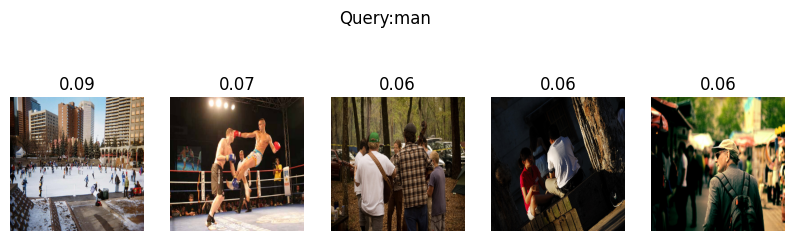

In [340]:
get_images('man','test_images','test_images_vectors',model,5,test_df)

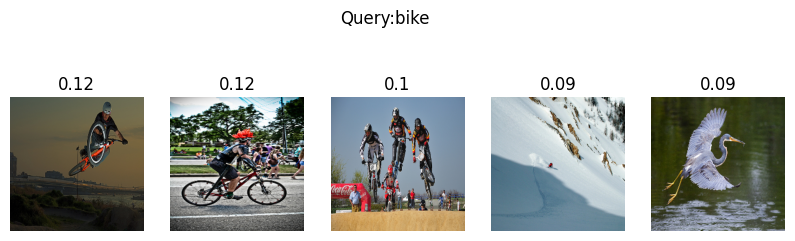

In [330]:
get_images('bike','test_images','test_images_vectors',model,5,test_df)

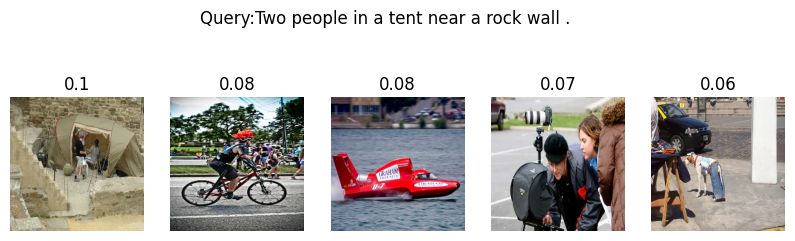

In [331]:
get_images('Two people in a tent near a rock wall .','test_images','test_images_vectors',model,5,test_df)

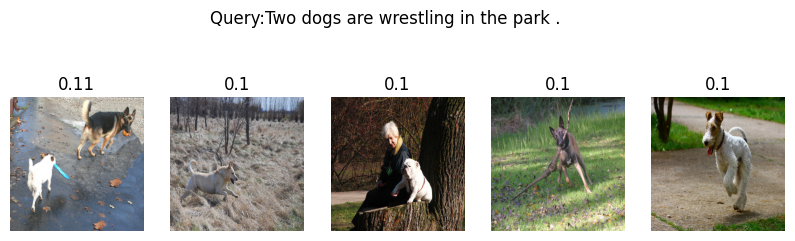

In [332]:
get_images('Two dogs are wrestling in the park .','test_images','test_images_vectors',model,5,test_df)

Из-за очень маленького тренировочного датасета, в выдаваемых изображениях попадаются те, что полностью отличаются от описания

In [254]:
get_images('Two boys.','test_images','test_images_vectors',model,5,test_df)

This image is unavailable in your country in compliance with local laws.


In [255]:
get_images('Children play in the garden.','test_images','test_images_vectors',model,5,test_df)

This image is unavailable in your country in compliance with local laws.


Программа корректно отображает дисклеймер в случае, если запрос может вести на незаконный контент

Также запустим несколько примером из тренировочного датасета

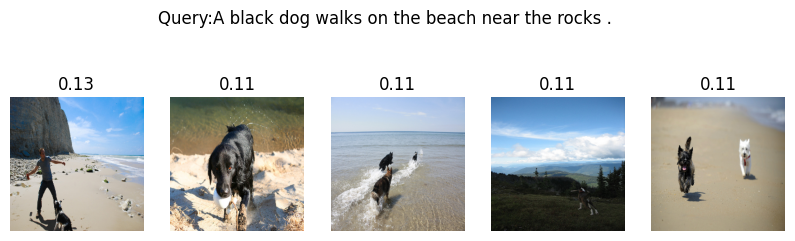

In [333]:
get_images('A black dog walks on the beach near the rocks .','train_images','train_images_vectors',model,5,df_train)

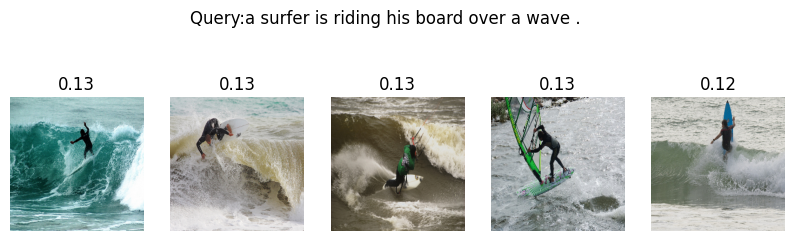

In [334]:
get_images('a surfer is riding his board over a wave .','train_images','train_images_vectors',model,5,df_train)

### Вывод

В качестве лучшей модель была использована CLIP

Размер тестовой выборки: 280

Accuracy@5 на тестовой выборке составила: 62%

Из-за очень маленького тренировочного датасета, в выдаваемых изображениях попадаются те, что полностью отличаются от описания

Программа корректно отображает дисклеймер в случае, если запрос может вести на незаконный контент

## Вывод

В качестве лучшей модель была использована CLIP

Модели обработки признаков:
<ul>
<li>Векторизация текста: all-mpnet-base-v2
<li>Векторизация изображений: google/vit-base-patch16-224
</ul>

В качестве определения схожести описания и изображения были использованы оценки, полученные от экспертов</br>
В качестве агрегированной оценки экспертов была нормализованная сумма оценок. При этом считается, что изображение соотвествует описанию, если агрегированная оценка составляет более 0.6

Размер тренировочной выборки: 847
Размер валидационной выборки: 219
Размер тестовой выборки: 280

Accuracy@5 на тренировочном датасете составила: 97%</br>
Accuracy@5 на валидационном датасете составила: 61%</br>
Accuracy@5 на тестовом датасете составила: 62%</br>

Из-за очень маленького тренировочного датасета, в выдаваемых изображениях попадаются те, что полностью отличаются от описания
Программа корректно отображает дисклеймер в случае, если запрос может вести на незаконный контент

**Рекомендации:** тренировочный датасет имеет очень маленький размер для такой задачи, из-за чего не удается правильно обучить модели, которые проецируют векторы текстов и изображений в одно пространство. Для дальнейшего улучшения качества модели необходимо значительно увеличить датасет, к примеру использовать оценки, полученные с помощью краудсорсинга (размер этого датасета - 40000). Также, в данном решении было решено заморозить сами модели векторизации, однако их дообучения вероятно также позволит увеличить точность

Исходя из полученных результатов, я могу сделать вывод, что данный проект практически осуществим. Даже при том, что модель была обучена всего на 847 изображениях, точность на тестовой выборке оказалась 62%, при этом метрика accuracy@5, подразумевает, что целевой объект должен находится в 5 лучших вариантах, полученных моделью, но здесь не учитывается, на сколько сами возвращенные изображения близки по смыслу к необходимому. Возможно такое, что модель не выбрала нужное изображение, но все равно при этом вернула изображения, схожие по смыслу с запросом и оригинальным изображением.
